# Simple Quadratic Estimator (QE)

We plot the convergence $\kappa$ and deflection $\hat \alpha_{LM} = \sqrt{L (L + 1)} \hat \phi_{LM}$

In [1]:
%matplotlib inline
import pylab as plt
import numpy as np
import lensit as li
import os
# Before starting, set the environment variable LENSIT to somewhere that is safe to write. 
# A bunch of stuff might get cached.
os.environ['LENSIT'] = '/tmp/lensit'

In [2]:
# some fiducial experimental configurations are defined, use Simons Observatory here

exp = li.get_config('SO')
print(exp)

ExptConfig(name='SO', sN_uKamin=3.0, sN_uKaminP=4.242640687119286, Beam_FWHM_amin=3.0, ellmin=10, ellmax=3000)


 I will be using data from ell=14 to ell=3000 only
 The sky band-limit is ell=6000
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:00])   inverse len Pmats  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:00])   Fxx , part 1  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:00])   Fyy , part 1  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:00])   Fxy , part 1  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:00])   Fxx , part 2  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:00])   Fyy , part 2  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:00])   Fxy , part 2  curvpOlm 
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
deflection: min, max =  -0.001844818868627327 0.001819622788599839
kappa: min, max =  -0.16810755144319522

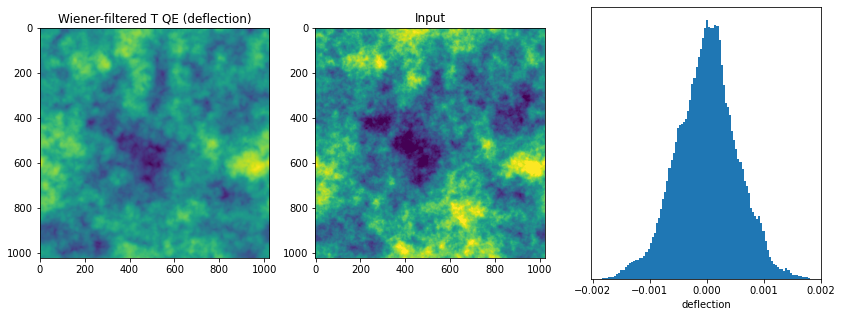

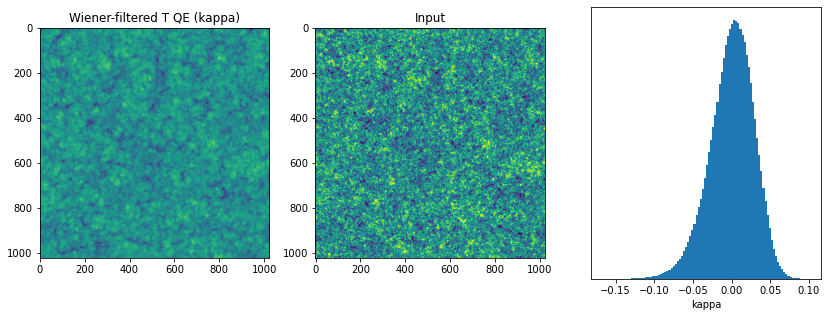

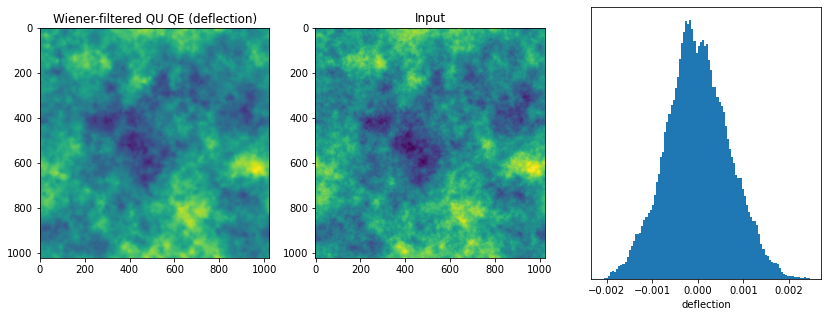

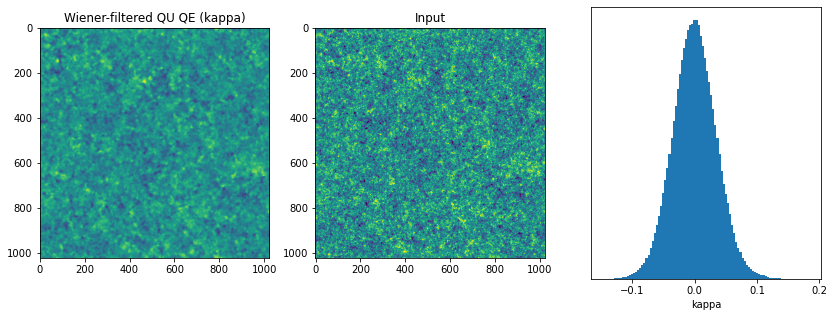

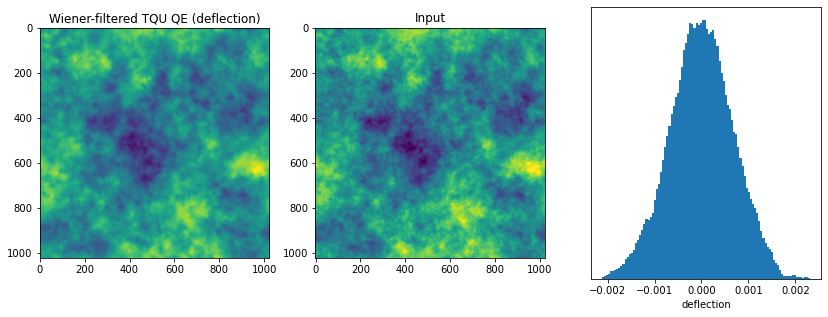

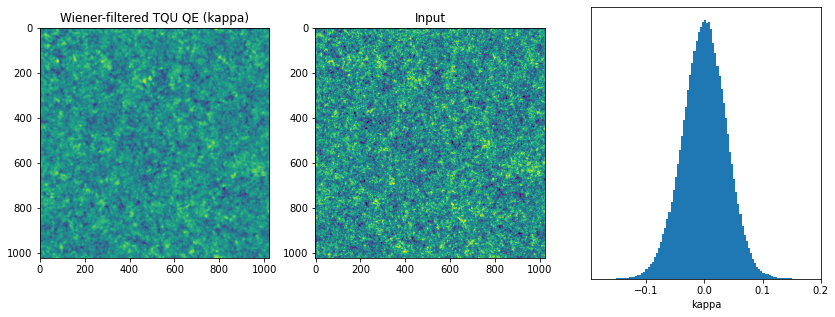

In [3]:
# just look at one simulation
nsims=1


# invert power spectrum without zero division
def cli(cl):
    ret = np.zeros_like(cl)
    ret[np.where(cl > 0)] = 1./cl[np.where(cl > 0)]
    return ret


sims = li.get_maps_lib(exp, 10, 11, nsims=nsims) # Simulation-library for configuration 'S4'. 
                                     # Parameters 10, 11 produces data on 645 sq. deg, 
                                     # with lensed CMB's generated at 0.75 arcmin resolution, 
                                     # but data collected at 1.5 arcmin resolution. 

isocov = li.get_isocov(exp, 10, 11) # Isotropic filtering instance, that can used for Q.E. calculation
                                     # and other things.isocov.lib_datalm defines the mode-filtering applied 
                                     # the data, and isocov.lib_skyalm the band-limits of the unlensed sky.

lib_qlm = isocov.lib_skyalm #: This means we will reconstruct the lensing potential for all unlensed sky modes.

def get_QE(idx, exp, estimator='T', wiener=False):
    """
    idx is simulation index
    exp is the name of the experiment, or ExptConfig instance
    estimator is T, QU or TQU
    wiener=true to Wiener-filter the output
    """
    
    print(" I will be using data from ell=%s to ell=%s only"%(isocov.lib_datalm.ellmin, isocov.lib_datalm.ellmax))
    print(" The sky band-limit is ell=%s"%(isocov.lib_skyalm.ellmax))
    
 
    # We now build the quadratic estimator. We use lensed CMB spectra in the weights.
    # the input for the quadratic estimator should be an n x n_alm array
    if estimator=='T':
        datalms = np.atleast_2d(isocov.lib_datalm.map2alm(sims.get_sim_tmap(idx)))
    elif estimator=='QU':
        datalms = np.array([isocov.lib_datalm.map2alm(m) for m in sims.get_sim_qumap(idx)])
    elif estimator=='TQU':
        datalms = np.array([isocov.lib_datalm.map2alm(m) for m in ([sims.get_sim_tmap(idx)]+list(sims.get_sim_qumap(idx)))])
    else:
        raise ValueError('Unknown estimator')
        
    response =  isocov.get_response(estimator, lib_qlm, use_cls_len=True)[0]
    phi_lm = 0.5 * isocov.get_qlms(estimator,  isocov.get_iblms(estimator, datalms, use_cls_len=True)[0], lib_qlm, 
                                 use_cls_len=True)[0]
    
    if wiener:
        # get the analytic N0 reconstruction noise
        N0 =  isocov.get_N0cls(estimator, lib_qlm, use_cls_len=True)[0]
        # fiducial lensing power spectrum
        cpp = li.get_fidcls()[0]['pp'][:lib_qlm.ellmax+1]
        # multiply a_lm by Wiener filter
        lib_qlm.almxfl(phi_lm, cpp*cli(N0 + cpp), inplace=True)
    
    # normalize the QE by the response
    return isocov.lib_skyalm.almxfl(phi_lm, cli(response))
    

def phi2alpha_lm(plm): 
    # make deflection (alpha) from phi_lm
    return lib_qlm.almxfl(plm, np.arange(lib_qlm.ellmax + 1))

def phi2kappa_lm(plm): 
    # make kappa from phi_lm
    return lib_qlm.almxfl(plm, np.arange(lib_qlm.ellmax + 1)**2/2)


def plot_compare(alm_QE, alm_in, est='', name=''):
    lensmap = lib_qlm.alm2map(alm_QE)
    print('%s: min, max = '%name, np.min(lensmap),np.max(lensmap))
    fig, ax = plt.subplots(1, 3, figsize=(14, 5))
    vmax = np.max(np.abs(lensmap))
    ax[0].imshow(lensmap, vmax=vmax, vmin=-vmax)
    ax[1].imshow(lib_qlm.alm2map(alm_in), vmax=vmax, vmin=-vmax)
    ax[0].set_title('Wiener-filtered %s QE (%s)'%(est, name))
    ax[1].set_title('Input')
    ax[2].hist(lensmap.reshape(-1), 100)
    ax[2].set_xlabel(name)
    ax[2].set_yticks([])

# quadratic estimator for simulation 0
    
for est in ['T','QU', 'TQU']:

    phi_lm = get_QE(0, exp, estimator=est,wiener=True)

    # the input phi map for simulation 0
    plm_input = lib_qlm.udgrade(sims.lencmbs.lib_skyalm, sims.lencmbs.get_sim_plm(0))

    # compare input and reconstructed deflection and convergence
    plot_compare(phi2alpha_lm(phi_lm), phi2alpha_lm(plm_input), est, 'deflection')

    plot_compare(phi2kappa_lm(phi_lm), phi2kappa_lm(plm_input), est, 'kappa')      